In [19]:
%matplotlib inline
import numpy as np
import yt
from galaxy_analysis import Galaxy
import matplotlib.pyplot as plt
from galaxy_analysis.plot.plot_styles import *
import deepdish as dd
import glob

from galaxy_analysis.utilities import utilities

In [4]:
wdir = "/media/aemerick/Seagate Expansion Drive/FlatironData/run11_30km/sn_H2atten_H2sh/"

ds = yt.load(wdir + 'DD0239/DD0239')
data = ds.all_data()

#gal = Galaxy('DD0369',wdir=wdir)

In [5]:
#gal.ds.derived_field_list

In [6]:
data['thermal_energy']

Parsing Hierarchy : 100%|██████████| 2382/2382 [00:00<00:00, 12463.61it/s]


YTArray([1.37330443e+12, 1.38117453e+12, 1.37932464e+12, ...,
         3.22705553e+11, 4.44269137e+11, 3.66920773e+11]) erg/g

In [7]:
#
# Define region
#
dL = 400 * yt.units.pc
region = None
above_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') > 0.8) & (obj['cylindrical_z'].in_units('kpc') < 1.2) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
above_hot_region = above_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
above_cold_region = above_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])

below_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') < -0.8) & np.abs(obj['cylindrical_z'].in_units('kpc') > -1.2) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
below_hot_region = below_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
below_cold_region = below_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])

In [8]:
directory = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh/py3temp/'
data = dd.io.load(directory + 'DD1000_galaxy_data.h5')

In [9]:
print(data['time_data']['time_100'])
#print(dd.io.load(directory+'DD0200_galaxy_data.h5','/meta_data/Time'))

[-3.19717726e+07  6.80282274e+07  1.68028227e+08  2.68028227e+08
  3.68028227e+08  4.68028227e+08  5.68028227e+08  6.68028227e+08
  7.68028227e+08  8.68028227e+08  9.68028227e+08]


In [ ]:
def correct_orate(directory):
    
    
    files = np.sort(glob.glob(directory + '/*galaxy_data*.h5'))
    all_times = np.zeros(np.size(files))
    
    for i,f in enumerate(files):
        meta_data    = dd.io.load(f,'/meta_data')
        all_times[i] = meta_data['Time']
        
        
    Omass = np.zeros(np.size())
    times = tdata['time_100']
    SNR   = tdata['SNII_snr_100']
    SFR   = tdata['SFR_100']
    
    Omass = np.zeros(np.size(SFR) + 1)
    
    
    for i,t in enumerate(times):
        index = np.argmin(np.abs(t/1.0E6-all_times))
        Omass[i] = dd.io.load(files[index],
                             '/gas_meta_data/masses/FullBox')['O'] +\
                   dd.io.load(files[index],
                              '/gas_meta_data/masses/OutsideBox')['O']
        
     
    

In [29]:
def compute_loading_denominators(directory):
    
    files     = np.sort(glob.glob(directory + '/*galaxy_data*.h5'))
    
    all_times  = np.zeros(np.size(files))
    #SFR    = np.zeros(np.size(files))
    #SNR    = np.zeros(np.size(files))
    #O_rate = np.zeros(np.size(files))
    
    for i,f in enumerate(files):
        meta_data = dd.io.load(f,'/meta_data')
        all_times[i] = meta_data['Time']
    #    SFR[i]   = meta_data['SFR_100']
    #    SNR[i]   = dd.io.load(f,'/time_data/SNII_snr_100')
    
    tdata = dd.io.load(files[-1], '/time_data')
    
    times = tdata['time_100']
    SNR   = tdata['SNII_snr_100']
    SFR   = tdata['SFR_100']
    
    Omass = np.zeros(np.size(SFR))
    
    
    for i,t in enumerate(times):
        index = np.argmin(np.abs(50.0 + t/1.0E6-all_times - all_times[0]))
        Omass[i] = dd.io.load(files[index],
                             '/gas_meta_data/masses/FullBox')['O'] +\
                   dd.io.load(files[index],
                              '/gas_meta_data/masses/OutsideBox')['O']
            
    Orate = np.zeros(np.size(SFR))
    Orate[:-1] = (Omass[1:] - Omass[:-1]) / (times[1:] - times[:-1])
    Orate[-1]  = Orate[-2]
    
    
        
    Omass = Omass / (100.0E6) # Oxygen production rate
    
        
    return times, SFR, SNR, Orate, Omass


t_100, SFR_100, SNR_100, Omass_100, old_O= compute_loading_denominators(directory)

t_100   = t_100 / 1.0E6 # in Myr

f_SFR   = lambda x: np.interp(x,t_100, SFR_100)
f_SNR   = lambda x: np.interp(x,t_100, SNR_100)
f_Omass = lambda x: np.interp(x,t_100, Omass_100)
f_Omass_old = lambda x: np.interp(x,t_100, old_O)

print(t_100)

[-31.97177262  68.02822738 168.02822738 268.02822738 368.02822738
 468.02822738 568.02822738 668.02822738 768.02822738 868.02822738
 968.02822738]


In [30]:
for t in datax['time']:
    print(f_Omass(t), f_Omass_old(t))

1.3883152914108343e-06 4.4817102259635376e-15
1.5101576729587116e-06 4.4817102259635376e-15
1.632000054506589e-06 4.4817102259635376e-15
1.7538424360544664e-06 4.4817102259635376e-15
1.8756848176023437e-06 4.4817102259635376e-15
1.9975271991502213e-06 4.4817102259635376e-15
2.1193695806980985e-06 4.4817102259635376e-15
2.241211962245976e-06 4.4817102259635376e-15
2.363054343793853e-06 4.4817102259635376e-15
2.4127093892138443e-06 4.804909886589311e-08
2.3514998930074113e-06 1.6989148041377048e-07
2.2902903968009783e-06 2.917338619616479e-07
2.2290809005945453e-06 4.1357624350952526e-07
2.167871404388112e-06 5.354186250574026e-07
2.106661908181679e-06 6.5726100660528e-07
2.0454524119752458e-06 7.791033881531574e-07
1.9842429157688123e-06 9.009457697010348e-07
1.9230334195623793e-06 1.0227881512489122e-06
1.8618239233559463e-06 1.1446305327967895e-06
1.800614427149513e-06 1.2664729143446669e-06
1.7394049309430798e-06 1.3883152958925443e-06
1.6781954347366468e-06 1.5101576774404216e-06
1.

In [31]:
data1   = np.genfromtxt('loading_factors.dat',names=True)
data2   = np.genfromtxt('loading_factors2.dat',names=True)

datax = {}
for k in data1.dtype.names:
    datax[k] = np.array(list(data1[k]) + list(data2[k])) # ew
    
#print(f_Omass(datax['time']))
ofile = open("orate.dat","w")
ofile.write("#time O_rate\n")
for t in datax['time']:
    ofile.write("%8.8E %8.8E\n"%(t,f_Omass(t)))
ofile.close()

In [84]:
#
# Define region
#

def compute_mass_outflow(ds, data):
    
    dL = 200.0 * yt.units.pc
    above_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') > 0.9) & (obj['cylindrical_z'].in_units('kpc') < 1.1) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
    above_hot_region = above_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
    above_cold_region = above_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])
    above_colder_region = above_region.cut_region(["obj['temperature'].in_units('K') < 1.0E4"])

    below_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') < -0.9) & np.abs(obj['cylindrical_z'].in_units('kpc') > -1.1) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
    below_hot_region = below_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
    below_cold_region = below_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])
    below_colder_region = below_region.cut_region(["obj['temperature'].in_units('K') < 1.0E4"]) 
    
    i = 0
    
    total_vals = np.zeros(3)
    metal_vals = np.zeros(3)
    
    for above_reg, below_reg in [(above_region, below_region),
                                 (above_hot_region,below_hot_region),
                                 (above_cold_region,below_cold_region)]:
                                # (above_colder_region,below_colder_region)]:
        
        M = above_reg['cell_mass'].to('Msun')
        O = above_reg['O_Density'].value / above_reg['Density'].value * M    
        v = above_reg['z-velocity'].to('km/s')
        select = v > 0
    
        total_outflow_rate = np.sum(M[select]*v[select]/dL).to('Msun/yr')
        metal_outflow_rate = np.sum(O[select]*v[select]/dL).to('Msun/yr')
    
        M = below_reg['cell_mass'].to('Msun')
        O = below_reg['O_Density'].value / below_reg['Density'].value * M
        v = below_reg['z-velocity'].to('km/s')
        select = v < 0
    
        total_outflow_rate += np.sum(-M[select]*v[select]/dL).to('Msun/yr')
        metal_outflow_rate += np.sum(-O[select]*v[select]/dL).to('Msun/yr')
    
        total_vals[i] = total_outflow_rate
        metal_vals[i] = metal_outflow_rate
        
        i = i + 1
    
    # now I need to compute the SFR and metal production rate
    
    
    return total_vals[0], total_vals[1], total_vals[2], metal_vals[0], metal_vals[1], metal_vals[2]
   
def compute_energy_outflow(ds, data):
    
    birth_mass = data['birth_mass']
    birth_time = data['creation_time'].to('Myr')
    pt = data['particle_type']

    t = ds.current_time.to('Myr')


    select = ((birth_mass > 8.0) * (birth_mass < 25.0)) * (pt > 11) * ((t - birth_time ) < 40*yt.units.Myr)

    N_SN = np.size(birth_mass[select])

    dL = 200 * yt.units.pc
    region = None
    above_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') > 0.9) & (obj['cylindrical_z'].in_units('kpc') < 1.1) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
    above_hot_region = above_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
    above_cold_region = above_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])
    above_colder_region = above_region.cut_region(["obj['temperature'].in_units('K') < 1.0E4"])

    below_region = data.cut_region(["(obj['cylindrical_z'].in_units('kpc') < -0.9) & np.abs(obj['cylindrical_z'].in_units('kpc') > -1.1) & (obj['cylindrical_radius'].in_units('kpc') < 2)"])
    below_hot_region = below_region.cut_region(["obj['temperature'].in_units('K') > 3.0E5"])
    below_cold_region = below_region.cut_region(["obj['temperature'].in_units('K') < 3.0E5"])
    below_colder_region = below_region.cut_region(["obj['temperature'].in_units('K') < 1.0E4"])


    vals = np.zeros(4)
    
    if N_SN == 0:
        print("No Supernova this time step")
        return vals
    
    
    i = 0
    for above_reg, below_reg in [(above_region, below_region),
                                 (above_hot_region,below_hot_region),
                                 (above_cold_region,below_cold_region),
                                 (above_colder_region,below_colder_region)]:
    
        M  = above_reg['cell_mass'].to('Msun')
        v  = above_reg['z-velocity'].to('km/s')
        cV = above_reg['cell_volume'].to('cm**(3)')
        KE = 0.5*M*above_reg['velocity_magnitude']**2
        
        select = v > 0                  
        above_E_out_therm = (v / dL * above_reg['thermal_energy'].to('erg/g') * M).to('erg/s')[select]
        above_E_out_kin   = (v / dL * KE).to('erg/s')[select]
    
        M  = below_reg['cell_mass'].to('Msun')
        v  = below_reg['z-velocity'].to('km/s')
        cV = below_reg['cell_volume'].to('cm**(3)')
        KE = 0.5*M*below_reg['velocity_magnitude']**2
        
        select = v < 0           
        below_E_out_therm = (-v / dL * below_reg['thermal_energy'].to('erg/g') * M).to('erg/s')[select]
        below_E_out_kin   = (-v / dL * KE).to('erg/s')[select]    
    
    
        E_out_therm = np.sum(above_E_out_therm) + np.sum(below_E_out_therm)
        E_out_kin   = np.sum(above_E_out_kin  ) + np.sum(below_E_out_kin  )
        E_out_tot   = E_out_therm + E_out_kin
    
        #print("Out-rate      :  %10.3E %10.3E %10.3E"%(E_out_therm.value, E_out_kin.value, E_out_tot.value))
        #x = N_SN*yt.units.erg*1.0E51 / ((40.0*yt.units.Myr).to('s'))
        x = 1.0
        #print("Loading Factor: %10.3E %10.3E %10.3E"%((E_out_therm/x).value, (E_out_kin/x).value, (E_out_tot/x).value))
    

        vals[i] = (E_out_tot/x).value * 3.154E7 # convert to erg / yr
        i = i + 1
    
    return vals

In [94]:
import glob
dsnames = np.sort(np.array(glob.glob(wdir + "DD??00/DD??00") + glob.glob(wdir+"DD??50/DD??50") +
                           glob.glob(wdir + "DD??25/DD??25") + glob.glob(wdir+"DD??75/DD??75")))

#print(dsnames)

dsnames = np.sort(np.array(glob.glob(wdir + "DD???5/DD???5") +glob.glob(wdir+"DD???0/DD???0")))

In [ ]:

j = 0
ds_select = dsnames[88:]



hot_loading = np.zeros(np.size(ds_select))
cold_loading = np.zeros(np.size(ds_select))
colder_loading = np.zeros(np.size(ds_select))

mass_load = np.zeros(np.size(ds_select))
mass_load_hot= np.zeros(np.size(ds_select))
mass_load_cold = np.zeros(np.size(ds_select))

metal_load = np.zeros(np.size(ds_select))
metal_load_hot = np.zeros(np.size(ds_select))
metal_load_cold = np.zeros(np.size(ds_select))


sfr = np.zeros(np.size(mass_load))
snr = np.zeros(np.size(sfr))
orate = np.zeros(np.size(snr))

loading = np.zeros(np.size(ds_select))

file = open("loading_factors_new.dat","w")

file.write("#time E_out E_hot_out E_cold_out E_colder_out M_out M_out_hot M_out_cold Metal_out Metal_out_hot Metal_out_cold SFR SNR O_rate\n")

times = np.zeros(np.size(ds_select))
for dsname in ds_select:
    ds = yt.load(dsname)
    data = ds.all_data()
    
    times[j] = ds.current_time.to('Myr')
    
    try:
        x,y,z,w = compute_energy_outflow(ds,data)
    except:
        continue
    
    loading[j]        = x
    hot_loading[j]    = y
    cold_loading[j]   = z
    colder_loading[j] = w
    
    mass_load[j], mass_load_hot[j], mass_load_cold[j], metal_load[j], metal_load_hot[j], metal_load_cold[j] = compute_mass_outflow(ds,data)
    
    sfr[j] = f_SFR(times[j])
    snr[j] = f_SNR(times[j])
    orate[j] = f_Omass(times[j])
    
    
    print("%5.2f Myr:   %10.3E  %10.3E  %10.3E  %10.3E"%(times[j],loading[j],hot_loading[j],cold_loading[j],colder_loading[j]))
    file.write("%5.2f %10.3E  %10.3E  %10.3E  %10.3E %10.3E %10.3E %10.3E %10.3E %10.3E %10.3E %10.3E %10.3E %10.3E\n"%(times[j],loading[j],hot_loading[j],cold_loading[j],colder_loading[j],
                                                              mass_load[j],mass_load_hot[j], mass_load_cold[j], metal_load[j], metal_load_hot[j], metal_load_cold[j]
                                                                                                   ,sfr[j],snr[j],orate[j]))
    file.flush()
    j = j + 1
    
file.close()

Parsing Hierarchy : 100%|██████████| 1869/1869 [00:00<00:00, 17831.42it/s]


440.00 Myr:    5.748E+44   2.789E+44   2.959E+44   1.198E+42


Parsing Hierarchy : 100%|██████████| 1598/1598 [00:00<00:00, 4338.04it/s]


445.00 Myr:    3.083E+44   6.964E+43   2.386E+44   1.385E+42


Parsing Hierarchy : 100%|██████████| 1633/1633 [00:00<00:00, 11904.14it/s]


450.00 Myr:    1.447E+44   2.304E+43   1.216E+44   5.863E+42


Parsing Hierarchy : 100%|██████████| 1561/1561 [00:00<00:00, 3303.54it/s]


455.00 Myr:    2.005E+44   1.191E+44   8.142E+43   7.365E+42


Parsing Hierarchy : 100%|██████████| 1523/1523 [00:00<00:00, 13565.04it/s]


460.00 Myr:    1.340E+44   3.652E+43   9.748E+43   4.213E+42


Parsing Hierarchy : 100%|██████████| 1641/1641 [00:00<00:00, 4116.98it/s]


465.00 Myr:    2.039E+44   9.179E+43   1.121E+44   3.517E+42


Parsing Hierarchy : 100%|██████████| 1614/1614 [00:00<00:00, 13486.56it/s]


470.00 Myr:    1.436E+44   4.094E+42   1.395E+44   7.184E+42


Parsing Hierarchy : 100%|██████████| 1662/1662 [00:00<00:00, 14943.85it/s]


475.00 Myr:    1.694E+44   3.278E+43   1.366E+44   4.407E+42


Parsing Hierarchy : 100%|██████████| 1609/1609 [00:00<00:00, 15003.10it/s]


480.00 Myr:    2.138E+44   1.249E+44   8.889E+43   3.266E+42


Parsing Hierarchy : 100%|██████████| 603/603 [00:00<00:00, 9967.94it/s]


485.00 Myr:    2.516E+44   1.176E+44   1.341E+44   3.355E+42


Parsing Hierarchy : 100%|██████████| 621/621 [00:00<00:00, 12350.40it/s]


490.00 Myr:    6.277E+43   1.086E+42   6.168E+43   6.699E+42


Parsing Hierarchy : 100%|██████████| 603/603 [00:00<00:00, 13265.53it/s]


495.00 Myr:    9.035E+43   1.102E+42   8.924E+43   3.134E+42


Parsing Hierarchy : 100%|██████████| 566/566 [00:00<00:00, 7439.46it/s]


No Supernova this time step
500.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 567/567 [00:00<00:00, 14484.96it/s]


No Supernova this time step
505.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1453/1453 [00:00<00:00, 4188.64it/s]


No Supernova this time step
510.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1482/1482 [00:00<00:00, 12434.45it/s]


No Supernova this time step
515.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1416/1416 [00:00<00:00, 4524.63it/s]


520.00 Myr:    1.269E+43   0.000E+00   1.269E+43   4.748E+42


Parsing Hierarchy : 100%|██████████| 1484/1484 [00:00<00:00, 14847.87it/s]


525.00 Myr:    1.539E+43   0.000E+00   1.539E+43   4.548E+42


Parsing Hierarchy : 100%|██████████| 1535/1535 [00:00<00:00, 4343.67it/s]


530.00 Myr:    1.185E+44   1.360E+42   1.172E+44   3.455E+42


Parsing Hierarchy : 100%|██████████| 1535/1535 [00:00<00:00, 15801.96it/s]


535.00 Myr:    1.676E+44   1.200E+43   1.556E+44   2.469E+42


Parsing Hierarchy : 100%|██████████| 1474/1474 [00:00<00:00, 14965.59it/s]


540.00 Myr:    2.859E+44   1.155E+44   1.704E+44   2.679E+42


Parsing Hierarchy : 100%|██████████| 1456/1456 [00:00<00:00, 4347.23it/s]


545.00 Myr:    1.200E+44   2.058E+43   9.944E+43   1.831E+42


Parsing Hierarchy : 100%|██████████| 1891/1891 [00:00<00:00, 14811.26it/s]


550.00 Myr:    2.016E+44   1.184E+44   8.324E+43   8.788E+41


Parsing Hierarchy : 100%|██████████| 1868/1868 [00:00<00:00, 4673.48it/s]


555.00 Myr:    6.536E+43   2.130E+43   4.406E+43   7.116E+41


Parsing Hierarchy : 100%|██████████| 2025/2025 [00:00<00:00, 5049.27it/s] 


560.00 Myr:    5.960E+44   2.956E+44   3.004E+44   7.796E+41


Parsing Hierarchy : 100%|██████████| 1921/1921 [00:00<00:00, 13888.06it/s]


565.00 Myr:    4.765E+44   2.319E+44   2.446E+44   1.134E+42


Parsing Hierarchy : 100%|██████████| 1831/1831 [00:00<00:00, 4631.52it/s]


570.00 Myr:    8.690E+44   3.243E+44   5.446E+44   3.085E+41


Parsing Hierarchy : 100%|██████████| 1947/1947 [00:00<00:00, 4504.40it/s] 


575.00 Myr:    7.808E+44   2.458E+44   5.350E+44   5.113E+40


Parsing Hierarchy : 100%|██████████| 1600/1600 [00:00<00:00, 14421.35it/s]


580.00 Myr:    9.899E+44   5.970E+44   3.929E+44   5.588E+38


Parsing Hierarchy : 100%|██████████| 1473/1473 [00:00<00:00, 4064.24it/s]


585.00 Myr:    7.808E+44   4.082E+44   3.726E+44   0.000E+00


Parsing Hierarchy : 100%|██████████| 1493/1493 [00:00<00:00, 16290.53it/s]


590.00 Myr:    6.530E+44   4.619E+44   1.911E+44   1.645E+41


Parsing Hierarchy : 100%|██████████| 1702/1702 [00:00<00:00, 3909.31it/s]


595.00 Myr:    1.506E+44   4.554E+43   1.051E+44   7.906E+41


Parsing Hierarchy : 100%|██████████| 1464/1464 [00:00<00:00, 15719.82it/s]


600.00 Myr:    1.817E+44   9.117E+43   9.055E+43   1.255E+42


Parsing Hierarchy : 100%|██████████| 1514/1514 [00:00<00:00, 15627.43it/s]


605.00 Myr:    7.891E+43   1.805E+43   6.086E+43   5.902E+41


Parsing Hierarchy : 100%|██████████| 1526/1526 [00:00<00:00, 4558.56it/s]


610.00 Myr:    9.721E+43   4.635E+42   9.258E+43   3.466E+42


Parsing Hierarchy : 100%|██████████| 1419/1419 [00:00<00:00, 15149.33it/s]


615.00 Myr:    2.896E+44   1.144E+44   1.752E+44   2.830E+42


Parsing Hierarchy : 100%|██████████| 497/497 [00:00<00:00, 14392.92it/s]


620.00 Myr:    7.029E+43   3.057E+42   6.723E+43   1.854E+42


Parsing Hierarchy : 100%|██████████| 468/468 [00:00<00:00, 12261.37it/s]


625.00 Myr:    4.250E+43   2.161E+43   2.089E+43   1.680E+42


Parsing Hierarchy : 100%|██████████| 460/460 [00:00<00:00, 15430.72it/s]


630.00 Myr:    2.441E+43   3.185E+41   2.409E+43   1.863E+42


Parsing Hierarchy : 100%|██████████| 534/534 [00:00<00:00, 13885.84it/s]


635.00 Myr:    5.532E+43   6.994E+42   4.832E+43   3.473E+42


Parsing Hierarchy : 100%|██████████| 435/435 [00:00<00:00, 15084.06it/s]


No Supernova this time step
640.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 447/447 [00:00<00:00, 13456.69it/s]


No Supernova this time step
645.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 429/429 [00:00<00:00, 12503.08it/s]


No Supernova this time step
650.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 460/460 [00:00<00:00, 11381.36it/s]


No Supernova this time step
655.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 419/419 [00:00<00:00, 15241.43it/s]


No Supernova this time step
660.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 420/420 [00:00<00:00, 9025.23it/s]


No Supernova this time step
665.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 421/421 [00:00<00:00, 9561.00it/s]


No Supernova this time step
670.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 382/382 [00:00<00:00, 11353.23it/s]


No Supernova this time step
675.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 384/384 [00:00<00:00, 10694.50it/s]


No Supernova this time step
680.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 416/416 [00:00<00:00, 11390.20it/s]


No Supernova this time step
685.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 416/416 [00:00<00:00, 1429.60it/s]


No Supernova this time step
690.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 397/397 [00:00<00:00, 12002.12it/s]


No Supernova this time step
695.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 417/417 [00:00<00:00, 15928.46it/s]


No Supernova this time step
700.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 409/409 [00:00<00:00, 15016.11it/s]


No Supernova this time step
705.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 364/364 [00:00<00:00, 12170.49it/s]


No Supernova this time step
710.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1167/1167 [00:00<00:00, 16009.27it/s]


No Supernova this time step
715.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1226/1226 [00:00<00:00, 16854.15it/s]


No Supernova this time step
720.00 Myr:    0.000E+00   0.000E+00   0.000E+00   0.000E+00


Parsing Hierarchy : 100%|██████████| 1231/1231 [00:00<00:00, 14483.40it/s]


725.00 Myr:    1.310E+42   0.000E+00   1.310E+42   1.826E+41


Parsing Hierarchy : 100%|██████████| 1326/1326 [00:00<00:00, 14933.12it/s]


730.00 Myr:    1.710E+42   0.000E+00   1.710E+42   1.669E+41


Parsing Hierarchy : 100%|██████████| 1248/1248 [00:00<00:00, 17030.60it/s]


735.00 Myr:    1.299E+44   2.136E+43   1.085E+44   1.395E+41


Parsing Hierarchy : 100%|██████████| 396/396 [00:00<00:00, 15262.95it/s]


740.00 Myr:    1.346E+44   2.020E+43   1.144E+44   9.603E+40


Parsing Hierarchy : 100%|██████████| 304/304 [00:00<00:00, 10436.50it/s]


745.00 Myr:    4.958E+44   3.971E+44   9.867E+43   6.662E+40


Parsing Hierarchy : 100%|██████████| 1143/1143 [00:00<00:00, 16532.03it/s]


750.00 Myr:    1.473E+44   8.006E+43   6.728E+43   1.801E+40


Parsing Hierarchy : 100%|██████████| 1209/1209 [00:00<00:00, 3265.54it/s]


755.00 Myr:    2.470E+44   1.959E+44   5.111E+43   6.702E+39


Parsing Hierarchy : 100%|██████████| 1382/1382 [00:00<00:00, 16996.32it/s]


760.00 Myr:    1.267E+44   9.012E+43   3.660E+43   0.000E+00


Parsing Hierarchy : 100%|██████████| 1300/1300 [00:00<00:00, 16493.78it/s]


765.00 Myr:    6.523E+43   9.123E+42   5.610E+43   8.192E+40


Parsing Hierarchy : 100%|██████████| 1451/1451 [00:00<00:00, 11767.26it/s]


770.00 Myr:    2.844E+44   7.165E+43   2.128E+44   1.395E+42


Parsing Hierarchy : 100%|██████████| 1509/1509 [00:00<00:00, 15282.95it/s]


775.00 Myr:    6.285E+44   3.172E+44   3.113E+44   2.307E+42


Parsing Hierarchy : 100%|██████████| 1493/1493 [00:00<00:00, 14628.64it/s]


780.00 Myr:    7.984E+44   5.285E+44   2.699E+44   3.021E+42


Parsing Hierarchy : 100%|██████████| 1267/1267 [00:00<00:00, 14597.12it/s]


785.00 Myr:    3.892E+44   2.573E+44   1.318E+44   2.351E+42


Parsing Hierarchy : 100%|██████████| 1254/1254 [00:00<00:00, 15059.30it/s]


790.00 Myr:    3.862E+44   2.090E+44   1.772E+44   3.439E+42


Parsing Hierarchy : 100%|██████████| 1241/1241 [00:00<00:00, 13848.70it/s]


795.00 Myr:    6.119E+44   3.241E+44   2.879E+44   1.225E+42


Parsing Hierarchy : 100%|██████████| 396/396 [00:00<00:00, 6689.40it/s]


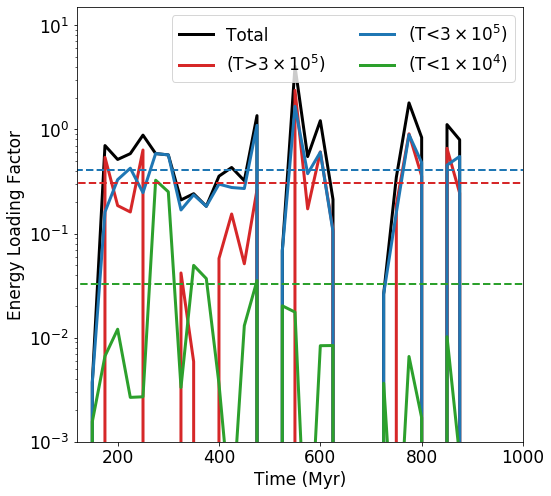

In [25]:

rc('font',size=17)

fig,ax=plt.subplots()
fig.set_size_inches(8,8)

ax.plot(times,loading,lw = 3,color='black',label='Total')
ax.plot(times,hot_loading,lw=3,color='C3',label=r'(T>$3 \times 10^5$)')
ax.plot(times,cold_loading,lw=3,color='C0',label=r'(T<$3 \times 10^5$)')
ax.plot(times,colder_loading,lw=3,color='C2',label=r'(T<$1 \times 10^4$)')


select = loading>0
ax.plot(ax.get_xlim(), [np.average(hot_loading[select])]*2, lw = 2, ls = '--', color = 'C3')
ax.plot(ax.get_xlim(), [np.average(cold_loading[select])]*2, lw = 2, ls = '--', color = 'C0')
ax.plot(ax.get_xlim(), [np.average(colder_loading[select])]*2, lw = 2, ls = '--', color = 'C2')

ax.legend(loc='best',ncol=2)

ax.set_ylim(1.0E-3,15.0)
ax.set_xlim(119.0,1000.0)
ax.semilogy()

ax.set_ylabel('Energy Loading Factor')
ax.set_xlabel('Time (Myr)')
fig.savefig('energy_loading.png')

In [17]:

rc('font',size=17)

fig,ax=plt.subplots()
fig.set_size_inches(8,8)

ax.plot(times,loading,lw = 3,color='black',label='Total')
ax.plot(times,hot_loading,lw=3,color='C3',label=r'(T>$3 \times 10^5$)')
ax.plot(times,cold_loading,lw=3,color='C0',label=r'(T<$3 \times 10^5$)')
ax.plot(times,colder_loading,lw=3,color='C2',label=r'(T<$1 \times 10^4$)')


select = loading>0
ax.plot(ax.get_xlim(), [np.average(hot_loading[select])]*2, lw = 2, ls = '--', color = 'C3')
ax.plot(ax.get_xlim(), [np.average(cold_loading[select])]*2, lw = 2, ls = '--', color = 'C0')
ax.plot(ax.get_xlim(), [np.average(colder_loading[select])]*2, lw = 2, ls = '--', color = 'C2')

ax.legend(loc='best',ncol=2)

ax.set_ylim(1.0E-3,15.0)
ax.set_xlim(119.0,1000.0)
ax.semilogy()

ax.set_ylabel('Energy Loading Factor')
ax.set_xlabel('Time (Myr)')
fig.savefig('energy_loading.png')

0.2140025542158142 0.2839159824908608 0.022821366943430607


In [88]:
data = np.genfromtxt('loading_factors.dat',names=True)

(1e-05, 1.0)

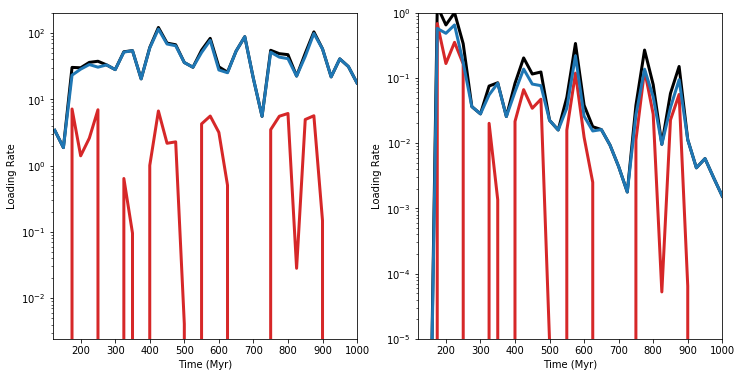

In [80]:
fig,axes = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax = axes[0]
ax.plot(data['time'], data['M_out'] / data['SFR'], color = 'black', lw = 3)
ax.plot(data['time'], data['M_out_hot'] / data['SFR'], color = 'C3', lw = 3)
ax.plot(data['time'], data['M_out_cold'] / data['SFR'], color = 'C0', lw = 3)
ax.semilogy()
ax.set_xlim(119,1000.0)
ax.set_xlabel('Time (Myr)')
ax.set_ylabel('$\eta_M')

ax = axes[1]
ax.plot(data['time'], data['Metal_out'] / data['O_rate'], color = 'black', lw = 3)
ax.plot(data['time'], data['Metal_out_hot'] / data['O_rate'], color = 'C3', lw = 3)
ax.plot(data['time'], data['Metal_out_cold'] / data['O_rate'], color = 'C0', lw = 3)
ax.semilogy()
ax.set_xlim(119,1000.0)
ax.set_xlabel('Time (Myr)')
ax.set_ylabel('$\eta_Z')
ax.set_ylim(0.00001,1.0)

Text(0, 0.5, '$\\eta_M')

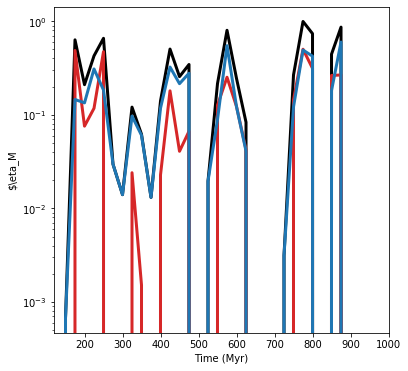

In [83]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)

ax.plot(data['time'], data['E_out'] / data['SNR'] / 1.0E51 *3.154E7, color = 'black', lw = 3)
ax.plot(data['time'], data['E_hot_out'] / data['SNR'] *3.154E7/ 1.0E51, color = 'C3', lw = 3)
ax.plot(data['time'], data['E_cold_out'] / data['SNR']*3.154E7 / 1.0E51, color = 'C0', lw = 3)
ax.semilogy()
ax.set_xlim(119,1000.0)
ax.set_xlabel('Time (Myr)')
ax.set_ylabel('$\eta_M')


In [91]:
# compute averages:

# convert to loading factors - compute averages
data = np.genfromtxt('loading_factors.dat',names=True)
loading_data = {}
for k in ['M_out','M_out_hot','M_out_cold']:
    loading_data[k] =   np.average( data[k] / data['SFR'])   
for k in ['Metal_out','Metal_out_hot','Metal_out_cold']:
    loading_data[k] =   np.average( data[k] / data['O_rate'])      
for k in ['E_out','E_hot_out','E_cold_out','E_colder_out']:
    loading_data[k] = np.average( data[k] / (data['SNR']*1.0E51))
    

# compute other values
loading_data['Eta_h-Eta_c'] = loading_data['E_hot_out'] / loading_data['E_cold_out']
loading_data['e_s'] = np.average(  data['E_out'] / (data['M_out']*1.989E33 )) # erg / g
loading_data['e_s_hot'] = np.average(  data['E_hot_out'] / (data['M_out_cold']*1.989E33 )) # erg / g
loading_data['e_s_cold'] = np.average(  data['E_cold_out'] / (data['M_out_cold']*1.989E33 )) # erg / g
loading_data['e_s_h-e_s_c'] = loading_data['e_s_hot'] / loading_data['e_s_cold']
for k in loading_data.keys():
    
    print("%20s  %8.3E"%(k,loading_data[k]))

In [93]:
for k in loading_data.keys():
    
    print("%20s  %8.3E"%(k,loading_data[k]))

               M_out  2.751E+01
           M_out_hot  5.399E-01
          M_out_cold  2.698E+01
           Metal_out  1.562E-02
       Metal_out_hot  1.561E-03
      Metal_out_cold  1.405E-02
               E_out  6.171E-02
           E_hot_out  1.647E-02
          E_cold_out  4.523E-02
        E_colder_out  4.587E-04
         Eta_h-Eta_c  3.641E-01
                 e_s  1.734E+13
             e_s_hot  4.828E+12
            e_s_cold  1.351E+13
         e_s_h-e_s_c  3.573E-01
